In [7]:
# Author: Farid Javadnejad
# Date: 2025-09-10
# Last Update: 2025-609-11
#
# DESCRIPTION:
# This script Generates and visualizes geotagging accuracy metrics for UAS image datasets.
# 
# DISCLAIMER:
# This script was developed with the assistance of AI tools for debugging, reviewing, and testing.
# ---------------------------------------------------------------------------------------------------

In [8]:
#pip install matplotlib
#%pip install plotly
#%pip install -U kaleido
#%pip install nbformat
#%pip install notebook ipywidgets nbformat


## Imports & Configuration

In [ ]:
# --- Setup: imports ---
import os
import math
import importlib.util
from pathlib import Path
from typing import Optional, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Ensure inline plotting
%matplotlib inline

# --- Global Configuration ---
READ_DIR = Path(r"P:\2025\NOGAL CANYON\01_CAPTURE\05_PHOTOGRAMMETRY")
OUTPUT_DIR = Path(r"P:\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS")
FILE_EXTENSION = ".jpg"
GEOTAG_FILE_NAME = "*geotags.csv"
REPORT_SUBDIR = "01_PREPROCESS_QC"
FALLBACK_DIR = Path(r"C:\temp")

# Columns from csv file
ACCU_H = "accuracy horizontal [meter]"
ACCU_V = "accuracy vertical [meter]"
LAT_COL = "latitude [decimal degrees]"
LON_COL = "longitude [decimal degrees]"
IMAGE_INDEX = "# image name"

## Functions

In [10]:
def count_files_by_extension(directory: Path, extension: str) -> int:
    return sum(1 for _, _, files in os.walk(directory) for file in files if file.lower().endswith(extension.lower()))

def load_geotag_csvs(base_path: Path, pattern: str = GEOTAG_FILE_NAME) -> Tuple[pd.DataFrame, int, int]:
    files = sorted(base_path.rglob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matching '{pattern}' found in: {base_path.resolve()}")

    frames = []
    for file in files:
        df = pd.read_csv(file, sep=None, engine="python")
        df.columns = df.columns.str.strip()
        df["source_name"] = file.name
        df["source_parent"] = file.parent.name
        frames.append(df)

    combined_df = pd.concat(frames, ignore_index=True)
    return combined_df, len(files), len(combined_df)

def prepare_output_dir(output_base: Path, source_base: Path) -> Tuple[Path, Path]:
    final_dir = (output_base / REPORT_SUBDIR) if output_base.exists() else FALLBACK_DIR / REPORT_SUBDIR
    final_dir.mkdir(parents=True, exist_ok=True)

    info_path = final_dir / "report.txt"
    with open(info_path, "w", encoding="utf-8") as f:
        f.write(
            f"Source base folder: {source_base.resolve()}\n"
            f"Folder name:        {source_base.name}\n"
            f"Prepared on:        {datetime.now().isoformat(timespec='seconds')}\n\n"
        )

    return final_dir, info_path


def save_combined_csv(df: pd.DataFrame, out_dir: Union[str, Path], filename: str = "combined_geotags.csv") -> Path:
    # Drop specified columns if they exist
    df = df.drop(columns=["source_name", "source_parent"], errors="ignore")

    # Ensure output directory exists
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Save to CSV
    out_path = out_dir / filename
    df.to_csv(out_path, index=False)
    print(f"✅ CSV saved to: {out_path.resolve()}")
    return out_path


def summarize_accuracy_metrics(df: pd.DataFrame, image_idx = IMAGE_INDEX, col_a = ACCU_H, col_b = ACCU_V):
    
    df[col_a] = pd.to_numeric(df[col_a], errors='coerce')
    df[col_b] = pd.to_numeric(df[col_b], errors='coerce')

    summary = pd.DataFrame({
        col_a: [df[col_a].min(), df[col_a].max(), df[col_a].mean(), df[col_a].std()],
        col_b: [df[col_b].min(), df[col_b].max(), df[col_b].mean(), df[col_b].std()]
    }, index=["min", "max", "mean", "std"]).T

    max10_col_a = df.sort_values(by=col_a, ascending=False).head(10)[[image_idx, col_a]]
    max10_col_b = df.sort_values(by=col_b, ascending=False).head(10)[[image_idx, col_b]]

    return summary, max10_col_a, max10_col_b



In [11]:
def plot_accuracy_vs_index(df: pd.DataFrame, output_dir: Path, filename_prefix: str = "accuracy_vs_index"):
    horiz_col = "accuracy horizontal [meter]"
    vert_col = "accuracy vertical [meter]"

    acc_h = pd.to_numeric(df[horiz_col], errors="coerce")
    acc_v = pd.to_numeric(df[vert_col], errors="coerce")
    valid_mask = acc_h.notna() | acc_v.notna()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df.index[valid_mask], acc_h[valid_mask], label=horiz_col, alpha=0.7)
    ax.scatter(df.index[valid_mask], acc_v[valid_mask], label=vert_col, alpha=0.7)
    ax.set_xlabel("Position Index")
    ax.set_ylabel("Accuracy [meter]")
    ax.set_title("Position Accuracy")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    output_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_dir / f"{filename_prefix}.png", dpi=150)
    print(f"✅ Accuracy plot saved to: {(output_dir / f'{filename_prefix}.png').resolve()}")


def plot_geotag_locations(
    df: pd.DataFrame,
    output_dir: Path,
    filename_prefix: str = "geo_map",
    lat_col: str = LAT_COL,          # your existing constants
    lon_col: str = LON_COL,          # your existing constants
    color_by_col: Optional[str] = None,
    color_scale: str = "Viridis",
    quantile_clip: Optional[Tuple[float, float]] = (0.02, 0.98),  # set to None to disable
    enable_color: bool = True,       # <-- new: explicit on/off switch
    colorbar_title: Optional[str] = None,  # optional override for colorbar title
    point_size: int = 9,
    point_opacity: float = 0.9,
):
    """
    Plot geotagged locations on a Mapbox map and (optionally) color points by a metric.
    """
    # Ensure numeric latitude/longitude
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df_valid = df.dropna(subset=[lat_col, lon_col])

    if df_valid.empty:
        print("⚠️ No valid coordinates to plot.")
        return

    # Compute map center and zoom
    lat_min, lat_max = df_valid[lat_col].min(), df_valid[lat_col].max()
    lon_min, lon_max = df_valid[lon_col].min(), df_valid[lon_col].max()
    center_lat = (lat_min + lat_max) / 2.0
    center_lon = (lon_min + lon_max) / 2.0
    max_range = max(lat_max - lat_min, lon_max - lon_min)
    zoom = 15 if max_range < 0.01 else 12 if max_range < 0.1 else 10 if max_range < 1 else 8 if max_range < 10 else 5
    # Decide whether to color
    use_color = bool(enable_color and color_by_col)
    range_color = None

    if use_color:
        if color_by_col in df_valid.columns:
            df_valid[color_by_col] = pd.to_numeric(df_valid[color_by_col], errors="coerce")
            s = df_valid[color_by_col].dropna()
            if not s.empty:
                if quantile_clip is not None:
                    low_q, high_q = quantile_clip
                    vmin = float(s.quantile(low_q))
                    vmax = float(s.quantile(high_q))
                    if vmin < vmax:
                        range_color = [vmin, vmax]
            else:
                print(f"ℹ️ Column '{color_by_col}' exists but has no numeric values; plotting without color scale.")
                use_color = False
        else:
            print(f"ℹ️ Column '{color_by_col}' not found; plotting without color scale.")
            use_color = False

    # Build figure
    fig = px.scatter_map(
        df_valid,
        lat=lat_col,
        lon=lon_col,
        color=color_by_col if use_color else None,
        color_continuous_scale=color_scale if use_color else None,
        range_color=range_color if use_color else None,
        hover_name="source_name" if "source_name" in df_valid.columns else None,
        hover_data={color_by_col: ':.2f'} if use_color else None,
        title="Geotag Locations Map",
        height=600,
        opacity=point_opacity,
        zoom=zoom,
    )


    fig.update_traces(marker=dict(size=point_size))

    fig.update_layout(
        map=dict(
            center={"lat": center_lat, "lon": center_lon},
            style="open-street-map",  # still works
            zoom=zoom
        ),
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
    )


    if use_color:
        fig.update_coloraxes(colorbar_title_text=(colorbar_title or str(color_by_col)))

    fig.show()

    output_dir.mkdir(parents=True, exist_ok=True)
    fig.write_image(output_dir / f"{filename_prefix}.png")
    fig.write_html(output_dir / f"{filename_prefix}.html")
    print(f"✅ Geotag map saved to: {(output_dir / f'{filename_prefix}.png').resolve()} and HTML")


## Run the Workflow

📸 Total '.jpg' files found: 2961
✅ Loaded 8 CSV files with 2,959 rows
✅ CSV saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\REPORT_GEOTAGGING_METRICS\01_PREPROCESS\combined_geotags.csv
📊 Summary Table:
                              min   max   mean    std
accuracy horizontal [meter]  0.02  0.32  0.025  0.009
accuracy vertical [meter]    0.03  0.44  0.050  0.021

Worst 10 Horizontal Accuracy:
                                # image name  accuracy horizontal [meter]
1995  250904_Nogal_RGB_5_Flight_03_00118.JPG                         0.32
1444  250904_Nogal_RGB_4_Flight_03_00041.JPG                         0.07
1445  250904_Nogal_RGB_4_Flight_03_00042.JPG                         0.07
760   250904_Nogal_RGB_4_Flight_02_00002.JPG                         0.07
1443  250904_Nogal_RGB_4_Flight_03_00040.JPG                         0.07
1405  250904_Nogal_RGB_4_Flight_03_00002.JPG                         0.06
1321  250904_Nogal_RGB_4_Flight_02_0056

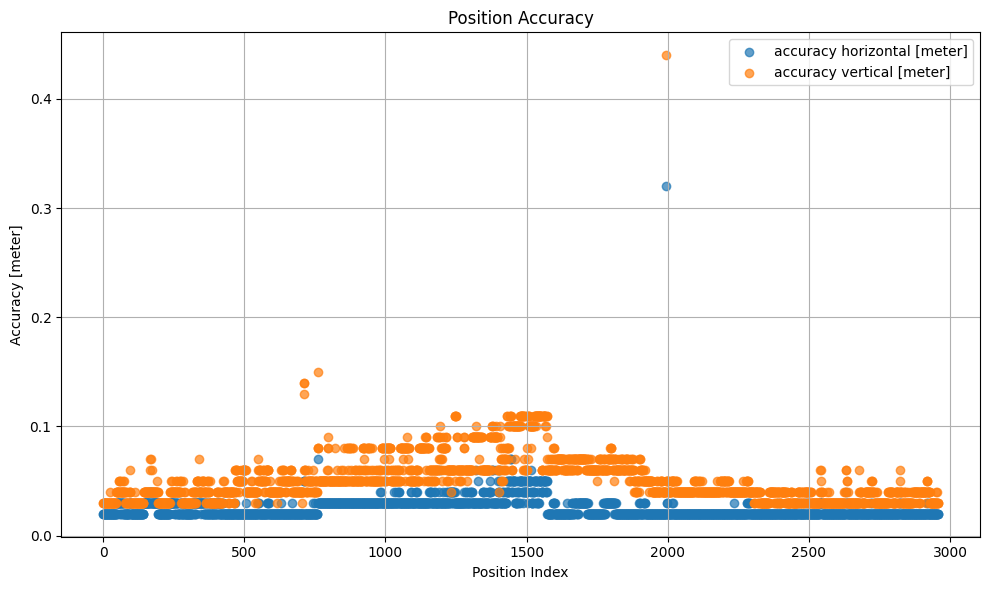

✅ Accuracy plot saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\REPORT_GEOTAGGING_METRICS\01_PREPROCESS\accuracy_vs_index.png


In [12]:
# Step 1: Count image files
total_images = count_files_by_extension(READ_DIR, FILE_EXTENSION)
print(f"📸 Total '{FILE_EXTENSION}' files found: {total_images}")

# Step 2: Load geotags
df, num_csvs, total_rows = load_geotag_csvs(READ_DIR)
print(f"✅ Loaded {num_csvs} CSV files with {total_rows:,} rows")

# Step 3: Prepare output directory
final_dir, report_path = prepare_output_dir(OUTPUT_DIR, READ_DIR)

# Step 4: Save combined CSV
csv_path = save_combined_csv(df, final_dir)

# Step 5: Summarize accuracy
summary, top10_horiz, top10_vert = summarize_accuracy_metrics(df)
print("📊 Summary Table:")
print(summary.round(3))
print("\nWorst 10 Horizontal Accuracy:")
print(top10_horiz)
print("\nWorst 10 Vertical Accuracy:")
print(top10_vert)

# Step 6: Plot accuracy
plot_accuracy_vs_index(df, output_dir=final_dir)

# Step 7: Append summary to report
with open(report_path, "a", encoding="utf-8") as f:
    f.write(f"\nTotal '{FILE_EXTENSION}' files found: {total_images}\n")
    f.write(f"Loaded {num_csvs} CSV files\n")
    f.write(f"Total rows: {total_rows:,}\n")
    f.write(f"CSV saved to: {csv_path.resolve()}\n\n")
    f.write("Summary Table:\n")
    f.write(summary.round(3).to_string())
    f.write("\n\nWorst 10 Horizontal Accuracy:\n")
    f.write(top10_horiz.to_string(index=True))
    f.write("\n\nWorst 10 Vertical Accuracy:\n")
    f.write(top10_vert.to_string(index=True))


In [13]:
plot_geotag_locations(
    df = df,
    output_dir=final_dir,
    filename_prefix = "geo_map",
    enable_color = False,
    point_size = 4,
    point_opacity = 1)

✅ Geotag map saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\REPORT_GEOTAGGING_METRICS\01_PREPROCESS\geo_map.png and HTML


In [15]:
plot_geotag_locations(
    df = df,
    output_dir=final_dir,
    color_by_col = ACCU_H,
    filename_prefix = "geo_map_1",
    enable_color = True,  
    colorbar_title =  ACCU_H,
    point_size = 6,
    point_opacity = 0.9)

✅ Geotag map saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\REPORT_GEOTAGGING_METRICS\01_PREPROCESS\geo_map_1.png and HTML


In [17]:
plot_geotag_locations(
    df = df,
    output_dir=final_dir,
    color_by_col = ACCU_V,
    filename_prefix = "geo_map_2",
    enable_color = True,  
    colorbar_title =  ACCU_V,
    point_size = 6,
    point_opacity = 0.9)

✅ Geotag map saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\REPORT_GEOTAGGING_METRICS\01_PREPROCESS\geo_map_2.png and HTML
